In [13]:
from sympy import diff, lambdify, symbols, sqrt, cos, numbered_symbols
from sympy import init_printing, latex
from sympy import S
from scipy.integrate import odeint
import numpy as np

init_printing(latex)
mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2, m1, M1, mu2, f27, f31 = symbols('mu1, mu2, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2, m1, M1, mu2, f27, f31')

In [14]:
class Pendulum(object):
    def __init__(self, t0, p0, theta0, l, m, g):
        self.t = t0
        self.p = p0
        self.theta = theta0
        self.vars = [self.p, self.theta]
        self.hamiltonian = p**2/2/m/l**2 - m*g*l*cos(theta)
        self.pdot = lambdify((p, theta), -diff(self.hamiltonian, theta), 'numpy')
        self.thetadot = lambdify((p, theta), -diff(self.hamiltonian, theta), 'numpy')
        def diffeq(y, t):
            dydt = [self.pdot(*y), self.thetadot(*y)]
            return dydt
        self.diffeq = diffeq
    def integrate(self, time):
        sol = odeint(self.diffeq, self.vars, [self.t, time])
        finalstate = sol[-1]
        self.p = finalstate[0]
        self.theta = finalstate[1]
        self.t = time

In [15]:
import math
import numpy as np

def wrap(val):
    while val < -np.pi:
        val += 2*np.pi
    while val > np.pi:
        val -= 2*np.pi
    return val

npwrap = np.vectorize(wrap)

def LaplaceCoefficient(s,j,a,n):
    j = abs(j)
    outside = 1
    for k in range(j):
        outside *= s+k
    outside *= 2./math.factorial(j)*a**(j-n)
    cterm = 1.
    cbterm = 1.
    for k in range(n):
        cbterm *= (j-k)
    csum = cbterm
    i=1
    while cbterm > np.finfo(float).eps or cbterm == 0:
        cterm = cterm*(s+i-1)*(s+j+i-1)/i/(j+i)*a**2
        cbterm = cterm
        for k in range(n):
            cbterm *= j+2*i-k
        csum += cbterm
        i+=1
    return outside*csum

In [26]:
class MMR1storder2body(object):
    def __init__(self, dt, t0, Lambda10, Lambda20, lambda10, lambda20, Gamma10, Gamma20, gamma10, gamma20, m1, M1, mu1, mu2, alpha, m):
        self.dt = dt
        self.t = t0
        self.Lambda1 = Lambda10
        self.Lambda2 = Lambda20
        self.lambda1 = lambda10
        self.lambda2 = lambda20
        self.Gamma1 = Gamma10
        self.Gamma2 = Gamma20
        self.gamma1 = gamma10
        self.gamma2 = gamma20
        self.m1 = m1
        self.M1 = M1
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha = alpha
        self.m = m
        self.f27 = 1/2*(-2*(m+1)*LaplaceCoefficient(0.5, m+1, self.alpha, 0) - alpha*LaplaceCoefficient(0.5, m+1, alpha, 1))
        self.f31 = 1/2*((2*m+1)*LaplaceCoefficient(0.5, m, alpha, 0) + alpha*LaplaceCoefficient(0.5, m, alpha, 1))
        
        Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2, m1, M1, mu1, mu2, f27, f31, alpha, m = symbols('Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2, m1, M1, mu1, mu2, f27, f31, alpha, m')
        self.varssym = [Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2]
        self.paramssym = [m1, M1, mu1, mu2, f27, f31, alpha, m]
        H0 = -mu1/(2*Lambda1**2) - mu2/(2*Lambda2**2)
        self.Hsym = H0 - m1/M1*mu2/Lambda2**2*(f27*sqrt(Gamma1/Lambda1)*cos((m+1)*lambda2 - m*lambda1 + gamma1) + f31*sqrt(2*Gamma2/Lambda2)*cos((m+1)*lambda2 - m*lambda1 + gamma2))
                
    @classmethod
    def from_sim(cls, sim, inner, outer, m):
        ps = sim.particles
        alpha = sim.particles[inner].a/sim.particles[outer].a
        m1jac = ps[inner].m*ps[0].m/(ps[inner].m+ps[0].m) # jacobi masses are reduced masses with masses interior
        m2jac = ps[outer].m*(ps[inner].m+ps[0].m)/(ps[outer].m+ps[inner].m+ps[0].m)
        M1jac = ps[0].m+ps[inner].m # jacobi Ms must multiply the jacobi masses to give m0*mN (N=1,2), see Deck Eq 1
        M2jac = ps[0].m*(ps[0].m+ps[inner].m+ps[outer].m)/(ps[0].m+ps[inner].m)
        mu1 = sim.G**2*M1jac**2*m1jac**3
        mu2 = sim.G**2*M2jac**2*m2jac**3
        Lambda1 = m1jac*np.sqrt(sim.G*M1jac*ps[inner].a)
        Lambda2 = m2jac*np.sqrt(sim.G*M2jac*ps[outer].a)
        lambda1 = ps[inner].l
        lambda2 = ps[outer].l
        Gamma1 = Lambda1*(1.-np.sqrt(1.-ps[inner].e**2))
        Gamma2 = Lambda2*(1.-np.sqrt(1.-ps[outer].e**2))
        gamma1 = -ps[inner].pomega
        gamma2 = -ps[outer].pomega
        dt = sim.particles[1].P/100.
        return cls(dt, sim.t, Lambda1, Lambda2, lambda1, lambda2, Gamma1, Gamma2, gamma1, gamma2, m1jac, M1jac, mu1, mu2, alpha, m)
    
    def integrate(self, times):
        self.H = self.Hsym
        for param in self.paramssym:
            self.H = self.H.subs(param, getattr(self, str(param)))
        
        self.Lambda1dotsym = -diff(self.Hsym, lambda1)
        self.Lambda2dotsym = -diff(self.Hsym, lambda2)
        self.Gamma1dotsym = -diff(self.Hsym, gamma1)
        self.Gamma2dotsym = -diff(self.Hsym, gamma2)
        self.lambda1dotsym = diff(self.Hsym, Lambda1)
        self.lambda2dotsym = diff(self.Hsym, Lambda2)
        self.gamma1dotsym = diff(self.Hsym, Gamma1)
        self.gamma2dotsym = diff(self.Hsym, Gamma2)
        
        self.Lambda1dot = lambdify(self.varssym, -diff(self.H, lambda1), 'numpy')
        self.Lambda2dot = lambdify(self.varssym, -diff(self.H, lambda2), 'numpy')
        self.Gamma1dot = lambdify(self.varssym, -diff(self.H, gamma1), 'numpy')
        self.Gamma2dot = lambdify(self.varssym, -diff(self.H, gamma2), 'numpy')
        self.lambda1dot = lambdify(self.varssym, diff(self.H, Lambda1), 'numpy')
        self.lambda2dot = lambdify(self.varssym, diff(self.H, Lambda2), 'numpy')
        self.gamma1dot = lambdify(self.varssym, diff(self.H, Gamma1), 'numpy')
        self.gamma2dot = lambdify(self.varssym, diff(self.H, Gamma2), 'numpy')
        
        def diffeq(y, t):
            dydt = [self.Lambda1dot(*y), self.Lambda2dot(*y), self.lambda1dot(*y), self.lambda2dot(*y), self.Gamma1dot(*y), self.Gamma2dot(*y), self.gamma1dot(*y), self.gamma2dot(*y)]
            #print(t, y, dydt)
            return dydt
        
        sol = odeint(diffeq, [getattr(self, str(symb)) for symb in self.varssym], times)
        return {'Lambda1':npwrap(sol[:,0]), 
                'Lambda2':npwrap(sol[:,1]), 
                'lambda1':npwrap(sol[:,2]), 
                'lambda2':npwrap(sol[:,3]), 
                'Gamma1':npwrap(sol[:,4]), 
                'Gamma2':npwrap(sol[:,5]), 
                'gamma1':npwrap(sol[:,6]), 
                'gamma2':npwrap(sol[:,7])}

In [32]:
import rebound

logmass = -5.1
e0 = 1.e-4 # initial eccentricity of planets
Norbits = 300 # number of inner planet orbits to integrate for
Nout = 1000
m=7

sim = rebound.Simulation()
sim.G = 4*np.pi**2
sim.add(m=1.)
sim.add(m=10**logmass, e=e0, P=1.)
sim.add(m=10**logmass, e=e0, P=(m+1)/m)
sim.move_to_com()

In [33]:
symsim = MMR1storder2body.from_sim(sim, 1, 2, m)

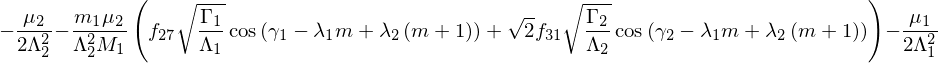

In [34]:
symsim.Hsym

In [35]:
%%time
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout, endpoint=False)
symsol = symsim.integrate(times)

Nsol = {'Lambda1':np.zeros(Nout), 'Lambda2':np.zeros(Nout), 'lambda1':np.zeros(Nout), 'lambda2':np.zeros(Nout), 
        'Gamma1':np.zeros(Nout), 'Gamma2':np.zeros(Nout), 'gamma1':np.zeros(Nout), 'gamma2':np.zeros(Nout)}
for i, time in enumerate(times):
    sim.integrate(time)
    Nsim = MMR1storder2body.from_sim(sim, 1, 2, m)
    for key in Nsol.keys():
        Nsol[key][i] = getattr(Nsim, key)

CPU times: user 3.78 s, sys: 19 ms, total: 3.8 s
Wall time: 3.82 s


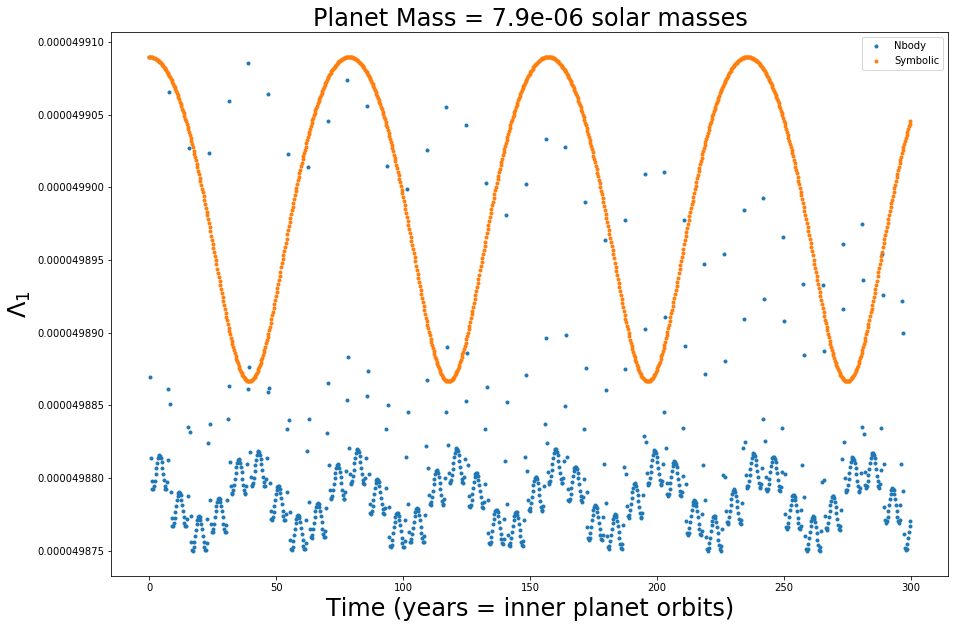

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_title("Planet Mass = {0:.1e} solar masses".format(10**logmass), fontsize=24)
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Lambda_1$", fontsize=24)

ax.plot(times, Nsol['Lambda1'], '.', label='Nbody')
ax.plot(times, symsol['Lambda1'], '.', label='Symbolic')

ax.legend()